In [1]:
from azureml.core import Workspace, Dataset, Environment

subscription_id = '92b2ba30-15c6-4cb9-bdc6-7dee778f2a6b'
resource_group = 'AzureML'
workspace_name = 'AzureML'

ws = Workspace(subscription_id, resource_group, workspace_name)

#### MNISTのデータを拾ってきて、ワークスペースのデータセットとして登録する

In [2]:
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

mnist_file_dataset = mnist_file_dataset.register(workspace=ws,
                                                 name='mnist_opendataset',
                                                 description='training and test dataset',
                                                 create_new_version=True)

#### ワークスペースのデータセットを使用する

In [3]:
dataset = Dataset.get_by_name(ws, name='mnist_opendataset')
dataset.download(target_path='./data/mnist2', overwrite=False)

array(['/mnt/batch/tasks/shared/LS_root/mounts/clusters/d3-v2/code/Users/yoshikazu_arimitsu/playground/data/mnist2/t10k-images-idx3-ubyte.gz',
       '/mnt/batch/tasks/shared/LS_root/mounts/clusters/d3-v2/code/Users/yoshikazu_arimitsu/playground/data/mnist2/t10k-labels-idx1-ubyte.gz',
       '/mnt/batch/tasks/shared/LS_root/mounts/clusters/d3-v2/code/Users/yoshikazu_arimitsu/playground/data/mnist2/train-images-idx3-ubyte.gz',
       '/mnt/batch/tasks/shared/LS_root/mounts/clusters/d3-v2/code/Users/yoshikazu_arimitsu/playground/data/mnist2/train-labels-idx1-ubyte.gz'],
      dtype=object)

In [4]:
import gzip
import numpy as np
import struct


# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]


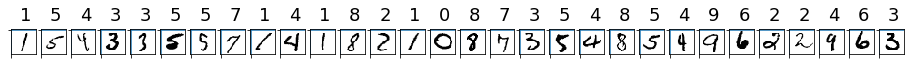

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
data_folder = './data/mnist2'
X_train = load_data(os.path.join(data_folder, "train-images-idx3-ubyte.gz"), False) / 255.0
X_test = load_data(os.path.join(data_folder, "t10k-images-idx3-ubyte.gz"), False) / 255.0
y_train = load_data(os.path.join(data_folder, "train-labels-idx1-ubyte.gz"), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, "t10k-labels-idx1-ubyte.gz"), True).reshape(-1)

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize=(16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()